In [24]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


## Data Cleaning
We downloaded both the financial fundamental and financial ratio data of North American companies from 2010-01-01 to 2020-12-31.

To perform data cleaning, we are going to merge the two data based on dates and company names. Then we will drop duplicated columns.

We also dropped missing rows and columns that has more than 30% of missing data. 

Last, we displayed the info of the cleaned data, and the summary statistics for the entire dataset, as well as the aggregated summary statistics for each company.

### Download and Merge data

In [4]:
ratios_df = pd.read_csv("data/company_ratios.csv")
fund_df = pd.read_csv("data/company_fundamentals.csv")

/tmp/ipykernel_8052/2249429491.py:2: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  fund_df = pd.read_csv("data/company_fundamentals.csv")


In [5]:
ratios_df.head()

,gvkey,adate,qdate,public_date,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,TICKER,cusip
0,1004,2009-05-31,2009-11-30,2010-01-31,0.082,0.201,0.095,0.651,0.498,0.466,3.586,186.451,2.272,1.001,AIR,00036110
1,1004,2009-05-31,2009-11-30,2010-02-28,0.082,0.201,0.095,0.651,0.498,0.466,3.586,186.451,2.272,1.001,AIR,00036110
2,1004,2009-05-31,2009-11-30,2010-03-31,0.082,0.201,0.095,0.651,0.498,0.466,3.586,186.451,2.272,1.001,AIR,00036110
3,1004,2009-05-31,2010-02-28,2010-04-30,0.081,0.195,0.086,0.676,0.473,0.545,3.893,183.882,2.312,0.987,AIR,00036110
4,1004,2009-05-31,2010-02-28,2010-05-31,0.081,0.195,0.086,0.676,0.473,0.545,3.893,183.882,2.312,0.987,AIR,00036110


In [6]:
fund_df.head()

,gvkey,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,conm,curcd,capx,oiadp,oibdp,opincar,sale,uapt,xacc,xopr,xoprar,costat,county,naics
0,1004,2010-05-31,2009.0,INDL,C,D,STD,AIR,000361105,AAR CORP,USD,28.855,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,A,NaN,423860.0
1,1004,2011-05-31,2010.0,INDL,C,D,STD,AIR,000361105,AAR CORP,USD,124.879,137.016,196.312,NaN,1775.782,NaN,116.839,1579.470,NaN,A,NaN,423860.0
2,1004,2012-05-31,2011.0,INDL,C,D,STD,AIR,000361105,AAR CORP,USD,91.218,142.360,222.693,NaN,2074.498,NaN,147.796,1851.805,NaN,A,NaN,423860.0
3,1004,2013-05-31,2012.0,INDL,C,D,STD,AIR,000361105,AAR CORP,USD,37.600,136.600,245.200,NaN,2167.100,NaN,152.100,1921.900,NaN,A,NaN,423860.0
4,1004,2014-05-31,2013.0,INDL,C,D,STD,AIR,000361105,AAR CORP,USD,26.500,142.600,256.000,NaN,2035.000,NaN,160.000,1779.000,NaN,A,NaN,423860.0


In [7]:
## Merge data
ratios_df['adate'] = pd.to_datetime(ratios_df['adate'])
fund_df['datadate'] = pd.to_datetime(fund_df['datadate'])

merged_df = pd.merge(
    ratios_df,
    fund_df,
    left_on=['gvkey', 'adate'],
    right_on=['gvkey', 'datadate'],
    how='inner'
)

In [8]:
merged_df.drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y', 'cusip_x','cusip_y', 'TICKER', "cusip", 'gvkey', "curcd", "tic" , "public_date", "costat","popsrc","datafmt","indfmt", "consol", "adate", "qdate","fyear"], inplace=True, errors='ignore')


In [9]:
merged_df

,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,datadate,conm,capx,oiadp,oibdp,opincar,sale,uapt,xacc,xopr,xoprar,county,naics
0,0.071,0.212,0.093,0.690,0.503,0.244,2.652,192.779,2.188,0.939,2010-05-31,AAR CORP,28.855,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,NaN,423860.0
1,0.071,0.212,0.093,0.690,0.503,0.244,2.652,192.779,2.188,0.939,2010-05-31,AAR CORP,28.855,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,NaN,423860.0
2,0.071,0.212,0.093,0.690,0.503,0.244,2.652,192.779,2.188,0.939,2010-05-31,AAR CORP,28.855,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,NaN,423860.0
3,0.077,0.186,0.078,0.694,0.477,0.343,3.219,180.501,2.344,0.972,2010-05-31,AAR CORP,28.855,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,NaN,423860.0
4,0.077,0.186,0.078,0.694,0.477,0.343,3.219,180.501,2.344,0.972,2010-05-31,AAR CORP,28.855,95.415,134.345,NaN,1352.151,NaN,106.548,1217.806,NaN,NaN,423860.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507946,-645.190,NaN,-0.561,0.856,0.354,2.743,2.945,2895.150,NaN,0.001,2019-12-31,ARMATA PHARMACEUTICALS INC,0.224,-17.989,-16.638,NaN,0.000,NaN,2.054,16.638,NaN,NaN,325414.0
507947,-59.082,NaN,-0.477,0.802,0.379,2.803,2.983,348.369,NaN,0.008,2019-12-31,ARMATA PHARMACEUTICALS INC,0.224,-17.989,-16.638,NaN,0.000,NaN,2.054,16.638,NaN,NaN,325414.0
507948,-59.082,NaN,-0.477,0.802,0.379,2.803,2.983,348.369,NaN,0.008,2019-12-31,ARMATA PHARMACEUTICALS INC,0.224,-17.989,-16.638,NaN,0.000,NaN,2.054,16.638,NaN,NaN,325414.0
507949,-0.868,0.625,-0.339,-0.780,0.528,1.180,1.631,130.301,NaN,0.329,2020-01-31,SNOWFLAKE INC,22.848,-358.088,-354.566,NaN,264.748,NaN,54.951,619.314,NaN,NaN,518210.0


### Drop missing columns and rows

In [10]:
## drop columns with more than 50% of NA
threshold = 0.3 * len(merged_df)
cleaned_df = merged_df.dropna(axis=1, thresh=threshold)


In [11]:
cleaned_df = cleaned_df.dropna()


In [12]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 201470 entries, 0 to 507926
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   opmad            201470 non-null  float64       
 1   gpm              201470 non-null  float64       
 2   roa              201470 non-null  float64       
 3   equity_invcap    201470 non-null  float64       
 4   debt_assets      201470 non-null  float64       
 5   cash_ratio       201470 non-null  float64       
 6   curr_ratio       201470 non-null  float64       
 7   cash_conversion  201470 non-null  float64       
 8   inv_turn         201470 non-null  float64       
 9   at_turn          201470 non-null  float64       
 10  datadate         201470 non-null  datetime64[ns]
 11  conm             201470 non-null  object        
 12  capx             201470 non-null  float64       
 13  oiadp            201470 non-null  float64       
 14  oibdp            201470 n

### Display data info and summary statistics

In [13]:
## set multiindex data based on company and dates
cleaned_df.set_index(['conm', 'datadate'], inplace=True)

In [14]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 201470 entries, ('AAR CORP', Timestamp('2010-05-31 00:00:00')) to ('ARCOSA INC', Timestamp('2019-12-31 00:00:00'))
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   opmad            201470 non-null  float64
 1   gpm              201470 non-null  float64
 2   roa              201470 non-null  float64
 3   equity_invcap    201470 non-null  float64
 4   debt_assets      201470 non-null  float64
 5   cash_ratio       201470 non-null  float64
 6   curr_ratio       201470 non-null  float64
 7   cash_conversion  201470 non-null  float64
 8   inv_turn         201470 non-null  float64
 9   at_turn          201470 non-null  float64
 10  capx             201470 non-null  float64
 11  oiadp            201470 non-null  float64
 12  oibdp            201470 non-null  float64
 13  sale             201470 non-null  float64
 14  xacc             201470 non-null  float64
 15

In [15]:
# Describe based on total dataset
cleaned_df.describe()

,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,capx,oiadp,oibdp,sale,xacc,xopr,naics
count,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000,201470.000000
mean,-1.275335,-0.966629,0.066094,0.626638,0.520769,1.247679,2.882521,115.139328,43.375914,1.080934,261.991528,515.086924,727.879487,4675.081909,291.053981,3947.202422,348005.149313
std,63.437533,70.323169,0.235045,1.363536,0.271578,2.098464,2.516681,824.763898,1195.535152,0.801213,1173.100764,1943.932817,2636.599115,18390.180575,1120.684392,16538.140663,143985.628016
min,-10597.000000,-9833.300000,-4.631000,-175.670000,0.015000,0.000000,0.049000,0.005000,0.000000,0.000000,0.000000,-25913.000000,-21913.000000,-1.977000,0.000000,0.925000,42.000000
25%,0.005000,0.230000,0.049000,0.498000,0.330000,0.203000,1.493000,41.606500,2.985000,0.582000,4.078000,1.114000,7.498000,151.029000,9.361000,146.431000,325412.000000
50%,0.069000,0.351000,0.109000,0.717000,0.512000,0.540000,2.183000,78.935000,5.037000,0.909000,25.411000,50.868000,85.400000,758.454000,42.170000,649.449000,334413.000000
75%,0.137000,0.499000,0.163000,0.964000,0.674000,1.401750,3.358000,130.033000,10.462000,1.395000,118.018000,284.300000,414.500000,2789.295500,166.898000,2307.700000,423690.000000
max,0.757000,1.085000,2.379000,21.135000,6.065000,68.216000,71.396000,139905.000000,120266.000000,22.698000,37985.000000,42959.000000,54559.000000,521426.000000,23683.000000,491287.000000,999990.000000


In [16]:
# Describe the data based on each company over the years
cleaned_df.groupby('conm').describe().transpose()


conm         1-800-FLOWERS.COM  ...  ZYLA LIFE SCIENCES
opmad count         101.000000  ...               3.000
      mean            0.040069  ...              -2.141
      std             0.011391  ...               0.000
      min             0.026000  ...              -2.141
      25%             0.034000  ...              -2.141
...                        ...  ...                 ...
naics min        455110.000000  ...          325412.000
      25%        455110.000000  ...          325412.000
      50%        455110.000000  ...          325412.000
      75%        455110.000000  ...          325412.000
      max        455110.000000  ...          325412.000

[136 rows x 2964 columns]

### Graph the Distribution of return on asset

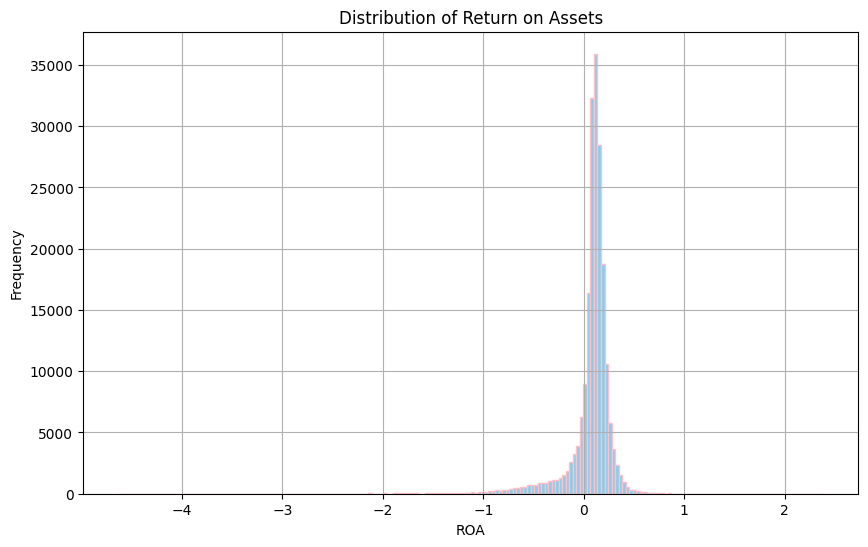

In [17]:
plt.figure(figsize=(10, 6))
cleaned_df['roa'].hist(bins=200, edgecolor='pink', color='skyblue')
plt.title('Distribution of Return on Assets')
plt.xlabel('ROA')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Correlation between predictor variables and outcome variable

In [19]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 201470 entries, ('AAR CORP', Timestamp('2010-05-31 00:00:00')) to ('ARCOSA INC', Timestamp('2019-12-31 00:00:00'))
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   opmad            201470 non-null  float64
 1   gpm              201470 non-null  float64
 2   roa              201470 non-null  float64
 3   equity_invcap    201470 non-null  float64
 4   debt_assets      201470 non-null  float64
 5   cash_ratio       201470 non-null  float64
 6   curr_ratio       201470 non-null  float64
 7   cash_conversion  201470 non-null  float64
 8   inv_turn         201470 non-null  float64
 9   at_turn          201470 non-null  float64
 10  capx             201470 non-null  float64
 11  oiadp            201470 non-null  float64
 12  oibdp            201470 non-null  float64
 13  sale             201470 non-null  float64
 14  xacc             201470 non-null  float64
 15

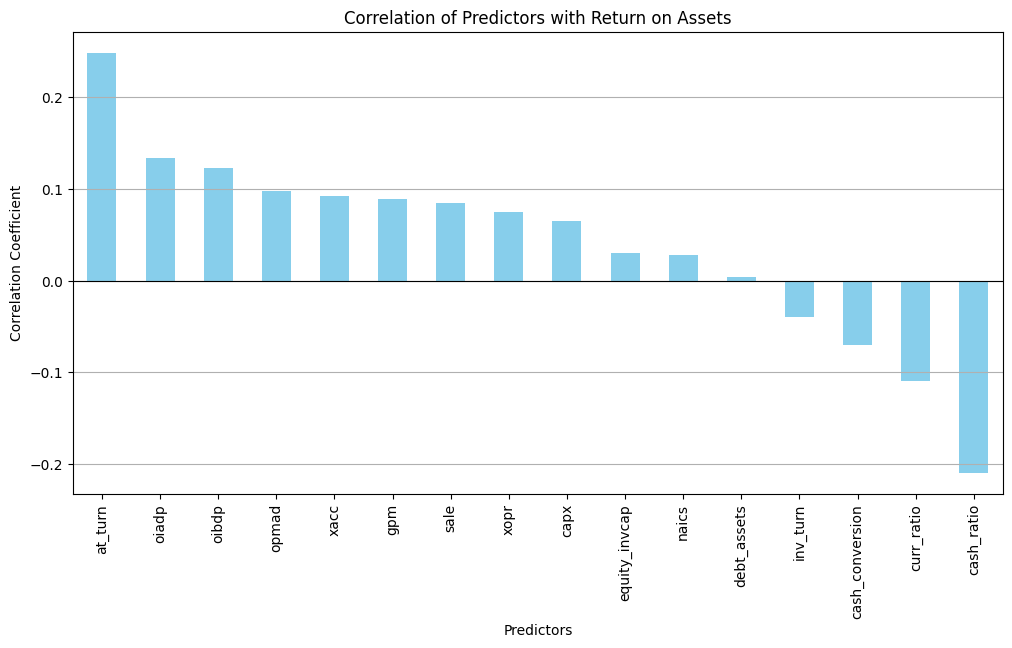

In [21]:
correlation_matrix = cleaned_df.corr()

# Step 2: Extract the correlations between 'roa' and the other predictors
roa_correlation = correlation_matrix['roa'].drop('roa').sort_values(ascending=False)

# Display the correlation values in a table
plt.figure(figsize=(12, 6))
roa_correlation.plot(kind='bar', color='skyblue')
plt.title('Correlation of Predictors with Return on Assets')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Predictors')
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y')
plt.show()


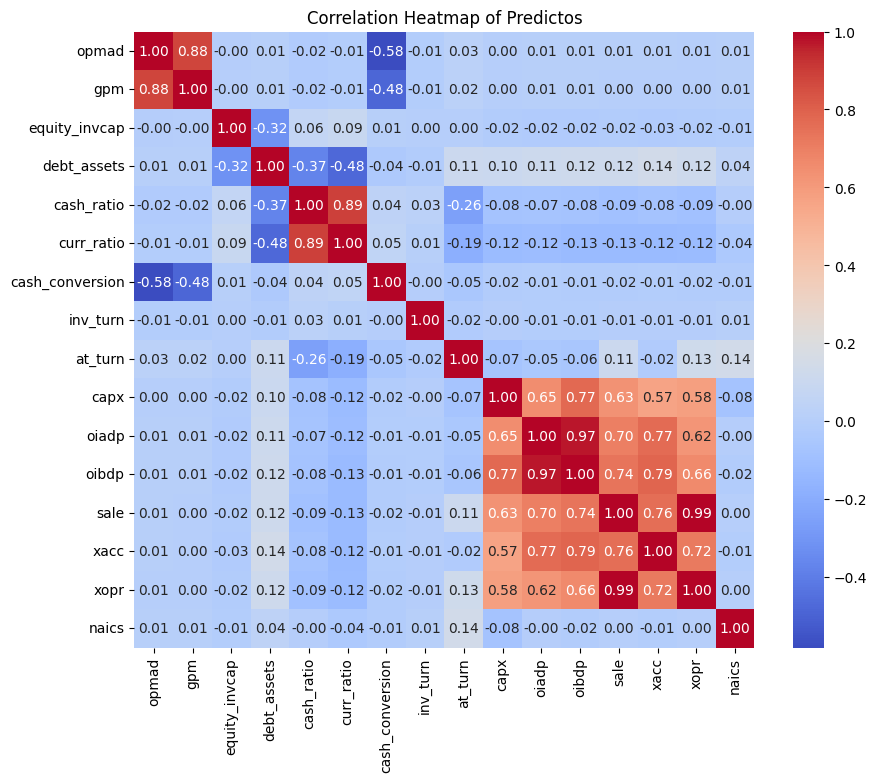

/home/mackenziequ/Projects/machinelearning/.venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Variance Inflation Factor (VIF):
           Variable        VIF
0             const  21.513490
1             opmad   5.102492
2               gpm   4.409131
3     equity_invcap   1.121198
4       debt_assets   1.483698
5        cash_ratio   5.427997
6        curr_ratio   5.909947
7   cash_conversion   1.527587
8          inv_turn   1.002355
9           at_turn   1.188376
10             capx   4.823975
11            oiadp  34.894564
12            oibdp        inf
13             sale        inf
14             xacc   3.409792
15             xopr        inf
16            naics   1.046467


In [25]:
predictors = ['opmad', 'gpm', 'equity_invcap', 'debt_assets', 'cash_ratio',
       'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'capx', 'oiadp',
       'oibdp', 'sale', 'xacc', 'xopr', 'naics']
X = cleaned_df[predictors]

#Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(X.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Predictos")
plt.show()

#Calculate VIF
X_with_const = sm.add_constant(X) # adding constant to VIF calculation
vif_data = pd.DataFrame({
    'Variable': X_with_const.columns,
    'VIF': [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]
})

print('Variance Inflation Factor (VIF):')
print(vif_data)

In [28]:
# Performing Principle Component Analysis

predictors = ['opmad', 'gpm', 'equity_invcap', 'debt_assets', 'cash_ratio',
       'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'capx', 'oiadp',
       'oibdp', 'sale', 'xacc', 'xopr', 'naics']

X = cleaned_df[predictors]
Y = cleaned_df['roa']

# Standardize the predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=None) # initially keep all components
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio for each principle component
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratio by Principal Component:")
for i, ev in enumerate(explained_variance, start=1):
    print(f"PC{i}: {ev:.2%}")

# Determine the number of components to explain 95% variance
cumulative_variance = explained_variance.cumsum()
n_components = (cumulative_variance < 0.95).sum() + 1
print(f"Using the first {n_components} principal components.")

# Reduce the dataset to the selectted number of components
X_pca_reduced = X_pca[:, :n_components]

# Perform regression using the reduced dataset
regressor = LinearRegression()
regressor.fit(X_pca_reduced, Y)

# Predict and evaluate the model
y_pred = regressor.predict(X_pca_reduced)
r2 = r2_score(Y, y_pred)
print(f"R-squared: {r2:.2f}")

# Coefficients of the principal components
coefficients = regressor.coef_
print(f"Regression Coefficients for the {n_components} Principal Components:")
for i, coef in enumerate(coefficients, start=1):
    print(f"PC{i}: {coef:.4f}")

Explained Variance Ratio by Principal Component:
PC1: 29.64%
PC2: 14.75%
PC3: 13.79%
PC4: 7.31%
PC5: 6.73%
PC6: 6.25%
PC7: 5.44%
PC8: 3.61%
PC9: 3.60%
PC10: 3.43%
PC11: 2.73%
PC12: 1.37%
PC13: 0.71%
PC14: 0.58%
PC15: 0.07%
PC16: 0.00%
Using the first 11 principal components.
R-squared: 0.12
Regression Coefficients for the 11 Principal Components:
PC1: 0.0135
PC2: 0.0239
PC3: -0.0092
PC4: 0.0374
PC5: -0.0076
PC6: -0.0079
PC7: -0.0151
PC8: -0.0521
PC9: -0.0106
PC10: 0.0172
PC11: -0.0228


## OLS regression data processing

We belive that the ROA of a given company can be predicted with the below estimators:
'opmad', 'gpm', 'roa', 'equity_invcap', 'debt_assets', 'cash_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'datadate', 'capx', 'oiadp', 'oibdp', 'opincar', 'sale', 'uapt', 'xacc','xopr', 'xoprar', 'county', 'naics'

$$
\text{ROA} = \beta_0 + \beta_1 \text{opmad} + \beta_2 \text{gpm} + \beta_3 \text{equity\_invcap} + \beta_4 \text{debt\_assets} 
$$
$$
+ \beta_5 \text{cash\_ratio} + \beta_6 \text{curr\_ratio} + \beta_7 \text{cash\_conversion} + \beta_8 \text{inv\_turn} $$ 
$$+ \beta_9 \text{at\_turn} + \beta_{11} \text{capx} + \beta_{12} \text{oiadp} + \beta_{13} \text{oibdp} + \beta_{14} \text{opincar} + \beta_{15}$$ 
$$ \text{sale} + \beta_{16} \text{uapt} + \beta_{17} \text{xacc} + \beta_{18} \text{xopr} + \beta_{19} \text{xoprar} + \beta_{20} \text{county} + \beta_{21} \text{naics} + \epsilon
$$


Where
opmad: Operating Margin, representing profitability from core operations.


gpm: Gross Profit Margin, indicating the percentage of revenue that exceeds the cost of goods sold.


equity_invcap: Equity to Invested Capital Ratio, reflecting the proportion of equity in the capital structure.


debt_assets: Debt to Assets Ratio, indicating leverage levels. 


cash_ratio: Cash Ratio, measuring liquidity by comparing cash and equivalents to current liabilities.


curr_ratio: Current Ratio, assessing the ability to cover short-term obligations.


cash_conversion: Cash Conversion Cycle, indicating how quickly a company converts investments into cash flows.


inv_turn: Inventory Turnover Ratio, showing how efficiently inventory is managed.


at_turn: Asset Turnover Ratio, indicating how effectively assets generate sales.


sale: Total sales or revenue.


capx: Capital Expenditure, representing funds used for acquiring or upgrading assets.


oiadp: Operating Income After Depreciation, reflecting core profitability.


oibdp: Operating Income Before Depreciation.


xacc: Accruals, showing non-cash adjustments to earnings.


xopr: Operating Expenses.

In [22]:
## Change the dates to month and year - drop full date column
cleaned_df = cleaned_df.reset_index()
cleaned_df['month'] = cleaned_df['datadate'].dt.month
cleaned_df['day'] = cleaned_df['datadate'].dt.day
cleaned_df = cleaned_df.drop(columns=['datadate'])

In [23]:
merged_df.columns

Index(['opmad', 'gpm', 'roa', 'equity_invcap', 'debt_assets', 'cash_ratio',
       'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'datadate',
       'conm', 'capx', 'oiadp', 'oibdp', 'opincar', 'sale', 'uapt', 'xacc',
       'xopr', 'xoprar', 'county', 'naics'],
      dtype='object')

In [24]:
# One-hot encode the "conm" column and remove other string columns

cleaned_df = pd.get_dummies(cleaned_df, columns=["conm"], dtype='int')
cleaned_df = cleaned_df.drop(cleaned_df.select_dtypes(['object']), axis=1)
cleaned_df

,opmad,gpm,roa,equity_invcap,debt_assets,cash_ratio,curr_ratio,cash_conversion,inv_turn,at_turn,...,conm_ZOETIS INC,conm_ZOGENIX INC,conm_ZOLL MEDICAL CORP,conm_ZOOM TECHNOLOGIES INC,conm_ZORAN CORP,conm_ZUMIEZ INC,conm_ZURN ELKAY WATER SOLUTI CORP,conm_ZW DATA ACTION TECHNOLGY INC,conm_ZYGO CORP,conm_ZYLA LIFE SCIENCES
0,0.071,0.212,0.093,0.690,0.503,0.244,2.652,192.779,2.188,0.939,...,0,0,0,0,0,0,0,0,0,0
1,0.071,0.212,0.093,0.690,0.503,0.244,2.652,192.779,2.188,0.939,...,0,0,0,0,0,0,0,0,0,0
2,0.071,0.212,0.093,0.690,0.503,0.244,2.652,192.779,2.188,0.939,...,0,0,0,0,0,0,0,0,0,0
3,0.077,0.186,0.078,0.694,0.477,0.343,3.219,180.501,2.344,0.972,...,0,0,0,0,0,0,0,0,0,0
4,0.077,0.186,0.078,0.694,0.477,0.343,3.219,180.501,2.344,0.972,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201465,0.092,0.251,0.117,0.892,0.256,0.668,2.712,94.890,4.667,0.774,...,0,0,0,0,0,0,0,0,0,0
201466,0.092,0.251,0.117,0.892,0.256,0.668,2.712,94.890,4.667,0.774,...,0,0,0,0,0,0,0,0,0,0
201467,0.092,0.251,0.117,0.892,0.256,0.668,2.712,94.890,4.667,0.774,...,0,0,0,0,0,0,0,0,0,0
201468,0.091,0.255,0.116,0.879,0.275,0.670,2.563,89.413,4.814,0.760,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X = cleaned_df.drop(columns=["roa", "month", "day"])
y = cleaned_df["roa"]

X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

print(model.summary())

: 

In [27]:
summary_table = pd.DataFrame({
    'Predictor': model.params.index,
    'Coefficient': model.params.values,
    'P-Value': model.pvalues.values,
    'Standard Error': model.bse.values,
    'Confidence Interval Lower': model.conf_int()[0],
    'Confidence Interval Upper': model.conf_int()[1]
})

# Display the table
summary_table

,Predictor,Coefficient,P-Value,Standard Error,Confidence Interval Lower,Confidence Interval Upper
const,const,-1871.845338,8.355505e-01,9017.095179,-19545.134903,15801.444227
opmad,opmad,0.000032,3.605243e-05,0.000008,0.000017,0.000048
gpm,gpm,0.000102,2.205492e-56,0.000006,0.000090,0.000115
equity_invcap,equity_invcap,0.000788,1.368536e-05,0.000181,0.000433,0.001143
debt_assets,debt_assets,-0.081141,0.000000e+00,0.001847,-0.084761,-0.077522
...,...,...,...,...,...,...
conm_ZUMIEZ INC,conm_ZUMIEZ INC,-169.801825,8.356391e-01,818.420485,-1773.886282,1434.282632
conm_ZURN ELKAY WATER SOLUTI CORP,conm_ZURN ELKAY WATER SOLUTI CORP,1870.458704,8.355424e-01,9009.967304,-15788.860396,19529.777805
conm_ZW DATA ACTION TECHNOLGY INC,conm_ZW DATA ACTION TECHNOLGY INC,-542.838285,8.356194e-01,2616.084218,-5670.300399,4584.623830
conm_ZYGO CORP,conm_ZYGO CORP,386.416549,8.355040e-01,1860.920778,-3260.943395,4033.776492


In [30]:
summary_table

,Predictor,Coefficient,P-Value,Standard Error,Confidence Interval Lower,Confidence Interval Upper
const,const,-1871.845338,8.355505e-01,9017.095179,-19545.134903,15801.444227
opmad,opmad,0.000032,3.605243e-05,0.000008,0.000017,0.000048
gpm,gpm,0.000102,2.205492e-56,0.000006,0.000090,0.000115
equity_invcap,equity_invcap,0.000788,1.368536e-05,0.000181,0.000433,0.001143
debt_assets,debt_assets,-0.081141,0.000000e+00,0.001847,-0.084761,-0.077522
...,...,...,...,...,...,...
conm_ZUMIEZ INC,conm_ZUMIEZ INC,-169.801825,8.356391e-01,818.420485,-1773.886282,1434.282632
conm_ZURN ELKAY WATER SOLUTI CORP,conm_ZURN ELKAY WATER SOLUTI CORP,1870.458704,8.355424e-01,9009.967304,-15788.860396,19529.777805
conm_ZW DATA ACTION TECHNOLGY INC,conm_ZW DATA ACTION TECHNOLGY INC,-542.838285,8.356194e-01,2616.084218,-5670.300399,4584.623830
conm_ZYGO CORP,conm_ZYGO CORP,386.416549,8.355040e-01,1860.920778,-3260.943395,4033.776492


### Regression results
We have filtered out all predictors with p-values less than 0.05, leaving only the predictors that are statistical significant.

The predictors with the largest absolute effects on ROA are at_turn, debt_assets, and cash_ratio. From the result, we can also categorize these predictors into positive predictors and negative predictors.

The predictors that are positively impacting the roa of a company are:
- opmad (Operating Margin): A small but significant positive coefficient (0.000032) indicates that higher operating margins are associated with slightly higher ROA.
- gpm (Gross Profit Margin): The positive coefficient (0.000102) suggests that as gross profit margins increase, so does ROA.
- equity_invcap (Equity to Invested Capital): A coefficient of 0.000788 implies that firms with higher equity relative to invested capital tend to have better ROA, as equity is associated with financial stability.
- cash_ratio and curr_ratio (Liquidity Ratios): Positive coefficients (0.004244 and 0.001998, respectively) highlight the importance of liquidity in driving better asset efficiency. This suggests firms with better liquidity management are more profitable.
- at_turn (Asset Turnover): The strongest positive predictor (0.114229), indicating that firms with higher asset turnover ratios significantly enhance ROA by efficiently using assets to generate revenue.

The negative predictors of ROA:

- debt_assets (Debt to Assets): A large negative coefficient (−0.081141) suggests that higher leverage (debt) significantly reduces ROA, as it increases financial risk and obligations.
- capx (Capital Expenditures): A small negative coefficient (−0.000006) indicates that higher capital expenditures slightly reduce ROA, potentially due to the upfront costs before returns materialize.
- xacc (Accruals): A small negative coefficient (−0.000003) suggests that larger accruals slightly diminish ROA, possibly reflecting earnings management practices.


In [25]:
significant_predictors = summary_table[summary_table['P-Value'] < 0.05]
print(significant_predictors)

                       Predictor  Coefficient       P-Value  Standard Error  \
opmad                      opmad     0.000032  3.605243e-05    7.859203e-06   
gpm                          gpm     0.000102  2.205492e-56    6.454350e-06   
equity_invcap      equity_invcap     0.000788  1.368536e-05    1.812090e-04   
debt_assets          debt_assets    -0.081141  0.000000e+00    1.846797e-03   
cash_ratio            cash_ratio     0.004244  2.844664e-19    4.728598e-04   
curr_ratio            curr_ratio     0.001998  3.533768e-07    3.923174e-04   
cash_conversion  cash_conversion     0.000007  1.096311e-85    3.811324e-07   
at_turn                  at_turn     0.114229  0.000000e+00    8.310614e-04   
capx                        capx    -0.000006  9.092444e-21    6.114787e-07   
oiadp                      oiadp     0.000008  1.853681e-11    1.155389e-06   
xacc                        xacc    -0.000003  2.368514e-03    1.062808e-06   

                 Confidence Interval Lower  Confide